In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
% matplotlib inline

/home/am/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class MLP:
    def __init__(self,n_input=2,n_hidden=4, n_output=1, act_func=[tf.nn.relu, tf.nn.sigmoid], learning_rate= 0.001):
        self.n_input = n_input # Number of inputs to the neuron
        self.act_fn = act_func
        seed = 456
        
        self.X = tf.placeholder(tf.float32, name='X', shape=[None,n_input])
        self.y = tf.placeholder(tf.float32, name='Y')
                
        # Build the graph for a single neuron
        # Hidden layer
        self.W1 = tf.Variable(tf.random_normal([n_input,n_hidden], stddev=2, seed = seed), name = "weights")
        self.b1 = tf.Variable(tf.random_normal([1, n_hidden], seed = seed), name="bias")
        tf.summary.histogram("Weights_Layer_1",self.W1)
        tf.summary.histogram("Bias_Layer_1", self.b1)
        
        
        # Output Layer
        self.W2 = tf.Variable(tf.random_normal([n_hidden,n_output], stddev=2, seed = seed), name = "weights")
        self.b2 = tf.Variable(tf.random_normal([1, n_output], seed = seed), name="bias")
        tf.summary.histogram("Weights_Layer_2",self.W2)
        tf.summary.histogram("Bias_Layer_2", self.b2)
               
        
        activity1 = tf.matmul(self.X, self.W1) + self.b1
        h1 = self.act_fn[0](activity1)
        
        activity2 = tf.matmul(h1, self.W2) + self.b2
        self.y_hat = self.act_fn[1](activity2)
        
        
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.y_hat, labels=self.y))
        self.opt =  tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)
        
        
        tf.summary.scalar("loss",self.loss)
        init = tf.global_variables_initializer()
        
        self.sess = tf.Session()
        self.sess.run(init)
        
        self.merge = tf.summary.merge_all()
        self.writer = tf.summary.FileWriter("logs/", graph=tf.get_default_graph())
        
        
        
    def train(self, X, Y, X_val, Y_val, epochs=100):
        epoch = 0
        X, Y = shuffle(X,Y)
        loss = []
        loss_val = []
        while epoch < epochs:
            # Run the optimizer for the whole training set batch wise (Stochastic Gradient Descent)    
            merge, _, l = self.sess.run([self.merge,self.opt,self.loss], feed_dict={self.X: X, self.y: Y})
            l_val = self.sess.run(self.loss, feed_dict={self.X: X_val, self.y: Y_val})
            
            loss.append(l)
            loss_val.append(l_val)
            self.writer.add_summary(merge, epoch)
                
            if epoch % 10 == 0:
                print("Epoch {}/{}  training loss: {} Validation loss {}".\
                      format(epoch,epochs,l, l_val ))
                
               
            epoch += 1
        return loss, loss_val
            
    def predict(self, X):
        return self.sess.run(self.y_hat, feed_dict={self.X: X})

In [3]:
filename = 'winequality-red.csv'  #Download the file from https://archive.ics.uci.edu/ml/datasets/wine+quality
df = pd.read_csv(filename, sep=';')
columns = df.columns.values
# Preprocessing and Categorizing wine into two categories
X, Y = df[columns[0:-1]], df[columns[-1]]
scaler = MinMaxScaler()
X_new = scaler.fit_transform(X)
#Y.loc[(Y<3.5)]=3
Y.loc[(Y<5.5) ] = 2
Y.loc[(Y>=5.5)] = 1
Y_new = pd.get_dummies(Y)  # One hot encode
X_train, X_val, Y_train, y_val = \
  train_test_split(X_new, Y_new, test_size=0.2, random_state=333)

/home/am/anaconda3/envs/tensorflow/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
_, d = X_train.shape
_, n = Y_train.shape
model = MLP(n_input=d, n_hidden=5, n_output=n)

In [5]:
loss, loss_val = model.train(X_train, Y_train, X_val, y_val, 10000)

Epoch 0/10000  training loss: 0.7775369882583618 Validation loss 0.7752965688705444
Epoch 10/10000  training loss: 0.7724501490592957 Validation loss 0.7697949409484863
Epoch 20/10000  training loss: 0.7675266861915588 Validation loss 0.7644182443618774
Epoch 30/10000  training loss: 0.762906551361084 Validation loss 0.7592542767524719
Epoch 40/10000  training loss: 0.7585335969924927 Validation loss 0.7544096112251282
Epoch 50/10000  training loss: 0.7543628811836243 Validation loss 0.7501053214073181
Epoch 60/10000  training loss: 0.7504240870475769 Validation loss 0.7462259531021118
Epoch 70/10000  training loss: 0.7465348243713379 Validation loss 0.7425655722618103
Epoch 80/10000  training loss: 0.742756724357605 Validation loss 0.7391285300254822
Epoch 90/10000  training loss: 0.7392124533653259 Validation loss 0.7359191179275513
Epoch 100/10000  training loss: 0.7360482811927795 Validation loss 0.7330106496810913
Epoch 110/10000  training loss: 0.7333075404167175 Validation loss 

Epoch 970/10000  training loss: 0.6816730499267578 Validation loss 0.680275559425354
Epoch 980/10000  training loss: 0.6811636686325073 Validation loss 0.6797801852226257
Epoch 990/10000  training loss: 0.6806437969207764 Validation loss 0.6792728304862976
Epoch 1000/10000  training loss: 0.6801129579544067 Validation loss 0.678753137588501
Epoch 1010/10000  training loss: 0.6795722842216492 Validation loss 0.6782246232032776
Epoch 1020/10000  training loss: 0.6790160536766052 Validation loss 0.6776813268661499
Epoch 1030/10000  training loss: 0.6784425973892212 Validation loss 0.6771241426467896
Epoch 1040/10000  training loss: 0.6778583526611328 Validation loss 0.6765502691268921
Epoch 1050/10000  training loss: 0.6772593855857849 Validation loss 0.6759544014930725
Epoch 1060/10000  training loss: 0.6766466498374939 Validation loss 0.6753301024436951
Epoch 1070/10000  training loss: 0.6760187149047852 Validation loss 0.6746846437454224
Epoch 1080/10000  training loss: 0.6753714084625

Epoch 2020/10000  training loss: 0.5744890570640564 Validation loss 0.5730522274971008
Epoch 2030/10000  training loss: 0.5741474628448486 Validation loss 0.572760283946991
Epoch 2040/10000  training loss: 0.5738109946250916 Validation loss 0.5724648237228394
Epoch 2050/10000  training loss: 0.5734818577766418 Validation loss 0.5721743106842041
Epoch 2060/10000  training loss: 0.5731623768806458 Validation loss 0.5718897581100464
Epoch 2070/10000  training loss: 0.5728490948677063 Validation loss 0.5716043710708618
Epoch 2080/10000  training loss: 0.5725417137145996 Validation loss 0.5713304281234741
Epoch 2090/10000  training loss: 0.5722435712814331 Validation loss 0.5710548162460327
Epoch 2100/10000  training loss: 0.5719587206840515 Validation loss 0.5707247257232666
Epoch 2110/10000  training loss: 0.5716820955276489 Validation loss 0.5704124569892883
Epoch 2120/10000  training loss: 0.5714117288589478 Validation loss 0.5701201558113098
Epoch 2130/10000  training loss: 0.571146488

Epoch 3090/10000  training loss: 0.5571812987327576 Validation loss 0.5556356310844421
Epoch 3100/10000  training loss: 0.5570957064628601 Validation loss 0.555559515953064
Epoch 3110/10000  training loss: 0.557009220123291 Validation loss 0.5555058717727661
Epoch 3120/10000  training loss: 0.5569234490394592 Validation loss 0.5554431676864624
Epoch 3130/10000  training loss: 0.55683833360672 Validation loss 0.5553659200668335
Epoch 3140/10000  training loss: 0.5567541718482971 Validation loss 0.5552896857261658
Epoch 3150/10000  training loss: 0.5566707253456116 Validation loss 0.5552160143852234
Epoch 3160/10000  training loss: 0.5565881729125977 Validation loss 0.5551388263702393
Epoch 3170/10000  training loss: 0.5565053224563599 Validation loss 0.5550637245178223
Epoch 3180/10000  training loss: 0.5564176440238953 Validation loss 0.5550419688224792
Epoch 3190/10000  training loss: 0.5563303828239441 Validation loss 0.5549942851066589
Epoch 3200/10000  training loss: 0.556243658065

Epoch 4130/10000  training loss: 0.55018550157547 Validation loss 0.5496405959129333
Epoch 4140/10000  training loss: 0.5501399636268616 Validation loss 0.5496176481246948
Epoch 4150/10000  training loss: 0.5500951409339905 Validation loss 0.5496047735214233
Epoch 4160/10000  training loss: 0.5500510931015015 Validation loss 0.5495849251747131
Epoch 4170/10000  training loss: 0.5500075817108154 Validation loss 0.549564003944397
Epoch 4180/10000  training loss: 0.5499646067619324 Validation loss 0.5495409965515137
Epoch 4190/10000  training loss: 0.549922525882721 Validation loss 0.5495113134384155
Epoch 4200/10000  training loss: 0.5498810410499573 Validation loss 0.54950350522995
Epoch 4210/10000  training loss: 0.5498402118682861 Validation loss 0.5495039224624634
Epoch 4220/10000  training loss: 0.549799919128418 Validation loss 0.5494945049285889
Epoch 4230/10000  training loss: 0.5497600436210632 Validation loss 0.5494845509529114
Epoch 4240/10000  training loss: 0.549720644950866

Epoch 5170/10000  training loss: 0.5466981530189514 Validation loss 0.5483942627906799
Epoch 5180/10000  training loss: 0.5466688275337219 Validation loss 0.5483989715576172
Epoch 5190/10000  training loss: 0.5466393828392029 Validation loss 0.548401951789856
Epoch 5200/10000  training loss: 0.5466099381446838 Validation loss 0.5484023094177246
Epoch 5210/10000  training loss: 0.5465804934501648 Validation loss 0.5484012365341187
Epoch 5220/10000  training loss: 0.5465509295463562 Validation loss 0.5483973622322083
Epoch 5230/10000  training loss: 0.5465213060379028 Validation loss 0.5483939051628113
Epoch 5240/10000  training loss: 0.5464916229248047 Validation loss 0.5483915209770203
Epoch 5250/10000  training loss: 0.546461820602417 Validation loss 0.5483881235122681
Epoch 5260/10000  training loss: 0.5464320778846741 Validation loss 0.5483843684196472
Epoch 5270/10000  training loss: 0.546402096748352 Validation loss 0.548378586769104
Epoch 5280/10000  training loss: 0.546372115612

Epoch 6210/10000  training loss: 0.5430244207382202 Validation loss 0.5476739406585693
Epoch 6220/10000  training loss: 0.5429865717887878 Validation loss 0.547659158706665
Epoch 6230/10000  training loss: 0.542948842048645 Validation loss 0.547644317150116
Epoch 6240/10000  training loss: 0.542911171913147 Validation loss 0.5476295351982117
Epoch 6250/10000  training loss: 0.5428736209869385 Validation loss 0.5476148128509521
Epoch 6260/10000  training loss: 0.5428360104560852 Validation loss 0.5475999712944031
Epoch 6270/10000  training loss: 0.5427985787391663 Validation loss 0.547585129737854
Epoch 6280/10000  training loss: 0.5427610874176025 Validation loss 0.5475702285766602
Epoch 6290/10000  training loss: 0.5427235960960388 Validation loss 0.5475552678108215
Epoch 6300/10000  training loss: 0.5426862835884094 Validation loss 0.5475402474403381
Epoch 6310/10000  training loss: 0.5426489114761353 Validation loss 0.54752516746521
Epoch 6320/10000  training loss: 0.542611718177795

Epoch 7250/10000  training loss: 0.5395282506942749 Validation loss 0.5464370846748352
Epoch 7260/10000  training loss: 0.5394997000694275 Validation loss 0.5464171767234802
Epoch 7270/10000  training loss: 0.5394713282585144 Validation loss 0.5463987588882446
Epoch 7280/10000  training loss: 0.5394431352615356 Validation loss 0.5463831424713135
Epoch 7290/10000  training loss: 0.5394150614738464 Validation loss 0.5463746190071106
Epoch 7300/10000  training loss: 0.5393869876861572 Validation loss 0.5463594198226929
Epoch 7310/10000  training loss: 0.5393591523170471 Validation loss 0.5463436841964722
Epoch 7320/10000  training loss: 0.5393314361572266 Validation loss 0.5463281869888306
Epoch 7330/10000  training loss: 0.539303183555603 Validation loss 0.5463050603866577
Epoch 7340/10000  training loss: 0.5392748117446899 Validation loss 0.5462913513183594
Epoch 7350/10000  training loss: 0.5392465591430664 Validation loss 0.5462794899940491
Epoch 7360/10000  training loss: 0.539218485

Epoch 8290/10000  training loss: 0.5371150970458984 Validation loss 0.5446707010269165
Epoch 8300/10000  training loss: 0.5370945930480957 Validation loss 0.5446664690971375
Epoch 8310/10000  training loss: 0.537074089050293 Validation loss 0.5446497797966003
Epoch 8320/10000  training loss: 0.5370537042617798 Validation loss 0.5446407198905945
Epoch 8330/10000  training loss: 0.5370333790779114 Validation loss 0.5446399450302124
Epoch 8340/10000  training loss: 0.5370131731033325 Validation loss 0.5446265339851379
Epoch 8350/10000  training loss: 0.5369929671287537 Validation loss 0.5446115732192993
Epoch 8360/10000  training loss: 0.5369729399681091 Validation loss 0.5445926785469055
Epoch 8370/10000  training loss: 0.5369529128074646 Validation loss 0.5445756912231445
Epoch 8380/10000  training loss: 0.5369328856468201 Validation loss 0.5445584654808044
Epoch 8390/10000  training loss: 0.5369130373001099 Validation loss 0.5445460081100464
Epoch 8400/10000  training loss: 0.536893188

Epoch 9330/10000  training loss: 0.5351248979568481 Validation loss 0.5434848070144653
Epoch 9340/10000  training loss: 0.535108208656311 Validation loss 0.5434865355491638
Epoch 9350/10000  training loss: 0.5350916981697083 Validation loss 0.5434718132019043
Epoch 9360/10000  training loss: 0.5350756049156189 Validation loss 0.5434803366661072
Epoch 9370/10000  training loss: 0.5350591540336609 Validation loss 0.543465793132782
Epoch 9380/10000  training loss: 0.5350427627563477 Validation loss 0.5434536337852478
Epoch 9390/10000  training loss: 0.5350268483161926 Validation loss 0.5434459447860718
Epoch 9400/10000  training loss: 0.5350110530853271 Validation loss 0.5434499979019165
Epoch 9410/10000  training loss: 0.5349947810173035 Validation loss 0.5434502959251404
Epoch 9420/10000  training loss: 0.5349787473678589 Validation loss 0.5434502959251404
Epoch 9430/10000  training loss: 0.5349631905555725 Validation loss 0.5434414744377136
Epoch 9440/10000  training loss: 0.5349411964

Text(0,0.5,'Cross Entropy Loss')

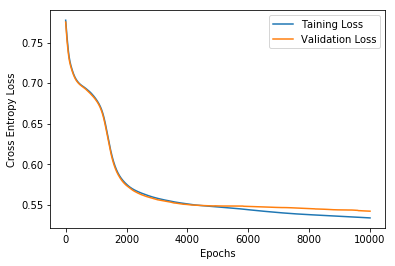

In [6]:
plt.plot(loss, label="Taining Loss")
plt.plot(loss_val, label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")

In [7]:
Y_pred = model.predict(np.float32(X_val))

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
accuracy = sum(np.argmax(Y_pred,1) == np.argmax(np.array(y_val),1))/len(y_val)
print(accuracy)

0.778125


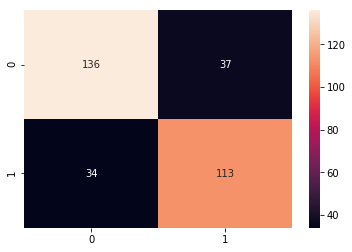

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
cm = confusion_matrix(np.argmax(np.array(y_val),1), np.argmax(Y_pred,1))
sns.heatmap(cm,annot=True,fmt='2.0f')

In [10]:
Y.value_counts()

1    855
2    744
Name: quality, dtype: int64